Dependencies

In [ ]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import normalize
import requests
from zipfile import ZipFile
import os
import json
import glob
import csv
import logging
from collections import Counter
import numpy as np
import torch
from sklearn.datasets import fetch_20newsgroups
from torch.autograd import Variable
from torch.utils.data import Dataset
from tqdm import tqdm

Data Downloading

In [ ]:
!pip install --user -U aicrowd-cli==0.1 
API_KEY = "YOURKEY"
!aicrowd login --api-key $API_KEY
!aicrowd dataset list --challenge spotify-million-playlist-dataset-challenge
!aicrowd dataset download --challenge spotify-million-playlist-dataset-challenge

In [ ]:
# loading the temp.zip and creating a zip object
with ZipFile("spotify_million_playlist_dataset.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall()


In [ ]:
def load_playlists(data_folder):
    all_playlists = []
    for file in glob.glob(data_folder + '/*.json'):
        with open(file, 'r') as f:
            data = json.load(f)
            playlists = data['playlists']
            for playlist in playlists:
                track_uris = [track['track_uri'] for track in playlist['tracks']]
                all_playlists.append(track_uris)
    return all_playlists

data_folder = './data'  # Replace with your actual path
playlists = load_playlists(data_folder)


In [ ]:
with open('playlists.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write each playlist to the file.
    for playlist in playlists:
        writer.writerow(playlist)

Model

In [14]:
# Hyperparameters
N_EMBEDDING = 300
BASE_STD = 0.01
BATCH_SIZE = 2048
NUM_EPOCH = 40
MIN_WORD_OCCURENCES = 100
X_MAX = 1000000 #unecesssary due to each song having relevant semantic weight
ALPHA = 0.75 
BETA = 0.0001
RIGHT_WINDOW = 0 #assuming no local context

USE_CUDA = torch.cuda.is_available()

FORMAT = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=FORMAT)


def cuda(x):
    if USE_CUDA:
        return x.cuda()
    return x


class WordIndexer:
    """Transform a dataset of songs to a list of index of songs."""

    def __init__(self, min_song_occurrences=1, right_window=1, oov_song="OOV"):
        self.oov_song = oov_song
        self.right_window = right_window
        self.min_song_occurrences = min_song_occurrences
        self.song_to_index = {oov_song: 0}
        self.index_to_song = [oov_song]
        self.song_occurrences = {}

    def _get_or_set_song_to_index(self, song):
        try:
            return self.song_to_index[song]
        except KeyError:
            idx = len(self.song_to_index)
            self.song_to_index[song] = idx
            self.index_to_song.append(song)
            return idx

    @property
    def n_songs(self):
        return len(self.song_to_index)

    def fit_transform(self, playlists):
        song_occurrences = Counter(song for playlist in playlists for song in playlist)

        self.song_occurrences = {
            song: n_occurrences
            for song, n_occurrences in song_occurrences.items()
            if n_occurrences >= self.min_song_occurrences}

        oov_index = 0
        return [[self._get_or_set_song_to_index(song)
                 if song in self.song_occurrences else oov_index
                 for song in playlist]
                for playlist in playlists]

    def _get_ngrams(self, indexes):
        for i, left_index in enumerate(indexes):
            window = indexes[i + 1:i + self.right_window + 1]
            for distance, right_index in enumerate(window):
                yield left_index, right_index, distance + 1

    def get_comatrix(self, data):
        comatrix = Counter()
        z = 0
        for indexes in data:
            l_ngrams = self._get_ngrams(indexes)
            for left_index, right_index, distance in l_ngrams:
                comatrix[(left_index, right_index)] += 1. / distance
                z += 1
        return zip(*[(left, right, x) for (left, right), x in comatrix.items()])


class GloveDataset(Dataset):
    def __len__(self):
        return self.n_obs

    def __getitem__(self, index):
        raise NotImplementedError()

    def __init__(self, playlists, right_window=1, random_state=0):
        torch.manual_seed(random_state)

        self.indexer = WordIndexer(right_window=right_window,
                                   min_song_occurrences=MIN_WORD_OCCURENCES)
        data = self.indexer.fit_transform(playlists)
        left, right, n_occurrences = self.indexer.get_comatrix(data)
        n_occurrences = np.array(n_occurrences)
        self.n_obs = len(left)
        
        self.L_words = cuda(torch.LongTensor(left))
        self.R_words = cuda(torch.LongTensor(right))

        self.weights = np.minimum((n_occurrences / X_MAX) ** ALPHA, 1)
        self.weights = Variable(cuda(torch.FloatTensor(self.weights)))
        self.y = Variable(cuda(torch.FloatTensor(np.log(n_occurrences))))
        N_WORDS = self.indexer.n_songs
        L_vecs = cuda(torch.randn((N_WORDS, N_EMBEDDING)) * BASE_STD)
        R_vecs = cuda(torch.randn((N_WORDS, N_EMBEDDING)) * BASE_STD)
        L_biases = cuda(torch.randn((N_WORDS,)) * BASE_STD)
        R_biases = cuda(torch.randn((N_WORDS,)) * BASE_STD)
        self.all_params = [Variable(e, requires_grad=True)
                           for e in (L_vecs, R_vecs, L_biases, R_biases)]
        self.L_vecs, self.R_vecs, self.L_biases, self.R_biases = self.all_params


def gen_batchs(data):
    """Batch sampling function"""
    indices = torch.randperm(len(data))
    if USE_CUDA:
        indices = indices.cuda()
    for idx in range(0, len(data) - BATCH_SIZE + 1, BATCH_SIZE):
        sample = indices[idx:idx + BATCH_SIZE]
        l_words, r_words = data.L_words[sample], data.R_words[sample]
        l_vecs = data.L_vecs[l_words]
        r_vecs = data.R_vecs[r_words]
        l_bias = data.L_biases[l_words]
        r_bias = data.R_biases[r_words]
        weight = data.weights[sample]
        y = data.y[sample]
        yield weight, l_vecs, r_vecs, y, l_bias, r_bias


def get_loss(weight, l_vecs, r_vecs, log_covals, l_bias, r_bias):
    sim = (l_vecs * r_vecs).sum(1).view(-1)
    x = (sim + l_bias + r_bias - log_covals) ** 2
    loss = torch.mul(x, weight)
    return loss.mean()


def train_model(data: GloveDataset):
    optimizer = torch.optim.Adam(data.all_params, weight_decay=1e-8)
    optimizer.zero_grad()
    for epoch in tqdm(range(NUM_EPOCH)):
        logging.info("Start epoch %i", epoch)
        num_batches = int(len(data) / BATCH_SIZE)
        avg_loss = 0.0
        n_batch = int(len(data) / BATCH_SIZE)
        for batch in tqdm(gen_batchs(data), total=n_batch, mininterval=1):
            optimizer.zero_grad()
            loss = get_loss(*batch)
            avg_loss += loss.item() / num_batches
            loss.backward()
            optimizer.step()
        logging.info("Average loss for epoch %i: %.5f", epoch + 1, avg_loss)

        logging.info("Average loss for epoch %i: %.5f", epoch + 1, avg_loss)

if __name__ == "__main__":
    logging.info("Build dataset")
    glove_data = GloveDataset(playlists, right_window=RIGHT_WINDOW)
    
    # Save the initial model parameters
    torch.save({
        'L_vecs': glove_data.L_vecs,
        'R_vecs': glove_data.R_vecs,
        'L_biases': glove_data.L_biases,
        'R_biases': glove_data.R_biases
    }, 'initial_model_parameters.pth')
    
    logging.info("#Songs: %s", glove_data.indexer.n_songs)
    logging.info("#Ngrams: %s", len(glove_data))
    logging.info("Start training")
    train_model(glove_data)

    # Save the final model parameters
    torch.save({
        'L_vecs': glove_data.L_vecs,
        'R_vecs': glove_data.R_vecs,
        'L_biases': glove_data.L_biases,
        'R_biases': glove_data.R_biases
    }, 'final_model_parameters.pth')


In [15]:
####LOADING THE MODEL####
with open('playlists.csv', 'r') as read_obj:
    # Return a reader object which will iterate over lines in the given csvfile
    csv_reader = csv.reader(read_obj)
  
    # Convert string to list
    playlists = list(csv_reader)
        
glove_data = GloveDataset(playlists, right_window=RIGHT_WINDOW)

# Load the saved parameters
saved_parameters = torch.load('final_model_parameters.pth')

# Use the saved parameters to initialize the new GloveDataset object
glove_data.L_vecs.data = saved_parameters['L_vecs'].data
glove_data.R_vecs.data = saved_parameters['R_vecs'].data
glove_data.L_biases.data = saved_parameters['L_biases'].data
glove_data.R_biases.data = saved_parameters['R_biases'].data

# Now you can use glove_data for further training, inference, etc.


In [ ]:
####GETTING THE EMBEDDINGS####
L_vecs = saved_parameters['L_vecs']
R_vecs = saved_parameters['R_vecs']

# Average the left and right vectors to get the final embeddings
embeddings = (L_vecs + R_vecs) / 2.0

API Calls to get Spotify Labels

In [13]:
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [14]:
client_credentials_manager = SpotifyClientCredentials(client_id='xxx', client_secret='xxx')
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
import pandas as pd
df = pd.DataFrame()

In [ ]:
for i in [x for x in range(300000) if x%350==0]:
    song_title = glove_data.indexer.index_to_song[i]
    features = sp.audio_features(song_title)[0]
    df = df.append(features, ignore_index=True)

In [27]:
df.to_csv('out.csv', index=False)

In [73]:
summary = df['energy'].describe()
print(summary)


count    857.000000
mean       0.632066
std        0.231873
min        0.003640
25%        0.479000
50%        0.678000
75%        0.824000
max        0.999000
Name: energy, dtype: float64


Creating Semantic Projection Transformers

In [74]:
max_idx = df['valence'].idxmax()
max_row = df.loc[max_idx]

min_idx = df['valence'].idxmin()
min_row = df.loc[min_idx]

In [75]:
max_row_id = max_row['uri']
min_row_id = min_row['uri']

In [76]:
max_embedding = embeddings[glove_data.indexer.song_to_index[max_row_id]]
min_embedding = embeddings[glove_data.indexer.song_to_index[min_row_id]]

In [78]:
tempo_axis = max_embedding - min_embedding

In [79]:
def size_project(name, axis):
    embedding = embeddings[glove_data.indexer.song_to_index[name]]
    size = torch.matmul(embedding, axis)
    size = size.cpu().detach().numpy()
    return size

In [85]:
df['Embedded Valence'] = df.apply(lambda row: size_project(row['uri'], tempo_axis), axis=1)

In [86]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,Embedded Tempo,Normalized Embedded Tempo,Embedded Energy,Embedded Valence
0,0.813,0.59600,2,-3.938,1,0.0578,0.00104,0.000000,0.1760,0.177,...,1GLcGInllpE4JUTStzaCOM,spotify:track:1GLcGInllpE4JUTStzaCOM,https://api.spotify.com/v1/tracks/1GLcGInllpE4...,https://api.spotify.com/v1/audio-analysis/1GLc...,214000,4,-0.043495324,0.37014,-0.040930748,-0.040930748
1,0.433,0.55400,9,-5.629,0,0.1650,0.76300,0.000000,0.0903,0.546,...,4DPezINQNrkmmzjasvltzW,spotify:track:4DPezINQNrkmmzjasvltzW,https://api.spotify.com/v1/tracks/4DPezINQNrkm...,https://api.spotify.com/v1/audio-analysis/4DPe...,165102,3,0.050054993,0.592069,-0.06397099,-0.06397099
2,0.691,0.63100,2,-6.478,1,0.0368,0.04830,0.000011,0.1040,0.800,...,48q0vSHcJdhK3IiXH8C5WJ,spotify:track:48q0vSHcJdhK3IiXH8C5WJ,https://api.spotify.com/v1/tracks/48q0vSHcJdhK...,https://api.spotify.com/v1/audio-analysis/48q0...,161124,4,-0.004814923,0.461902,0.09752078,0.09752078
3,0.292,0.67800,10,-5.595,1,0.0724,0.19200,0.000000,0.1460,0.365,...,0tjfognbowyFM3RHTdxjPK,spotify:track:0tjfognbowyFM3RHTdxjPK,https://api.spotify.com/v1/tracks/0tjfognbowyF...,https://api.spotify.com/v1/audio-analysis/0tjf...,220403,4,-0.0036878425,0.464575,-0.010242733,-0.010242733
4,0.450,0.00364,7,-28.649,0,0.0436,0.99400,0.917000,0.1180,0.120,...,1QsY3bO4cgW3v14Glqe67U,spotify:track:1QsY3bO4cgW3v14Glqe67U,https://api.spotify.com/v1/tracks/1QsY3bO4cgW3...,https://api.spotify.com/v1/audio-analysis/1QsY...,324708,3,-0.002513208,0.467362,0.0013842992,0.0013842992


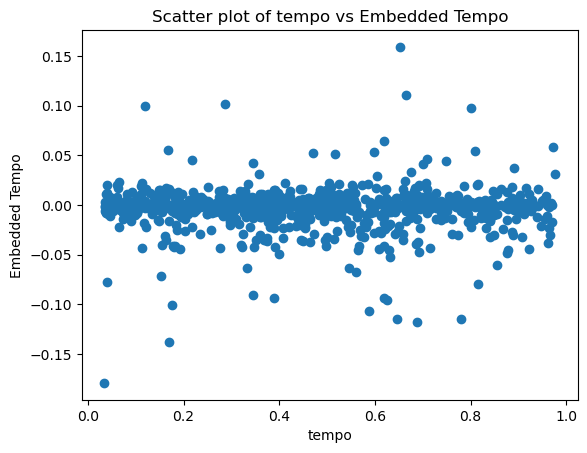

In [88]:
import matplotlib.pyplot as plt
plt.scatter(df['valence'], df['Embedded Valence'])
plt.xlabel('tempo')
plt.ylabel('Embedded Tempo')
plt.title('Scatter plot of tempo vs Embedded Tempo')
plt.show()


In [89]:
# Min-max normalization
df['Normalized Embedded Valence'] = (df['Embedded Valence'] - df['Embedded Valence'].min()) / (df['Embedded Valence'].max() - df['Embedded Valence'].min())

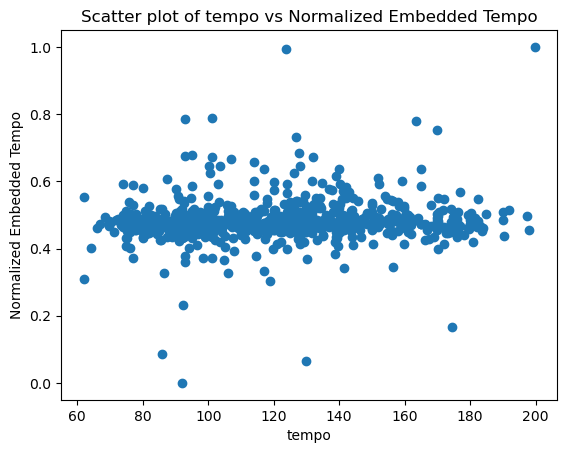

In [90]:
import matplotlib.pyplot as plt
plt.scatter(df['tempo'], df['Normalized Embedded Tempo'])
plt.xlabel('tempo')
plt.ylabel('Normalized Embedded Tempo')
plt.title('Scatter plot of tempo vs Normalized Embedded Tempo')
plt.show()
